In [2]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
#from model import VariationalLayer, VariationalNet

#from train import TrainDecoupledElbo

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [4]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 0
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [5]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {0.03} {2.0}

------------------EPOCH 1------------------
DATA LOSS 	 train 0.96 valid 0.51
KL LOSS 	 train 150.57 valid 136.2
ELBO LOSS 	 train 151.53 valid 136.71
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.45
KL LOSS 	 train 122.53 valid 109.4
ELBO LOSS 	 train 123.01 valid 109.85
------------------EPOCH 3------------------
DATA LOSS 	 train 0.41 valid 0.36
KL LOSS 	 train 97.18 valid 85.83
ELBO LOSS 	 train 97.59 valid 86.19
------------------EPOCH 4------------------
DATA LOSS 	 train 0.34 valid 0.33
KL LOSS 	 train 76.25 valid 67.46
ELBO LOSS 	 train 76.6 valid 67.79
------------------EPOCH 5------------------
DATA LOSS 	 train 0.32 valid 0.29
KL LOSS 	 train 60.83 valid 54.89
ELBO LOSS 	 train 61.15 valid 55.18
------------------EPOCH 6------------------
DATA LOSS 	 train 0.3 valid 0.3
KL LOSS 	 train 50.61 valid 46.88
ELBO LOSS 	 train 50.91 valid 47.18
------------------EPOCH 7------------------
DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 44.14 valid 41.

DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 14.05 valid 14.17
ELBO LOSS 	 train 14.3 valid 14.43
------------------EPOCH 57------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 13.92 valid 13.89
ELBO LOSS 	 train 14.17 valid 14.14
------------------EPOCH 58------------------
DATA LOSS 	 train 0.25 valid 0.27
KL LOSS 	 train 13.78 valid 13.72
ELBO LOSS 	 train 14.03 valid 13.99
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 13.68 valid 13.65
ELBO LOSS 	 train 13.93 valid 13.9
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.26
KL LOSS 	 train 13.62 valid 13.68
ELBO LOSS 	 train 13.86 valid 13.94
------------------EPOCH 61------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 13.55 valid 13.66
ELBO LOSS 	 train 13.8 valid 13.91
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 13.43 valid 13.4
ELBO LOSS 	 train 13.68 valid 13.66
------

k_list = [ 0.001, 0.003, 0.01, 0.03, 0.1]
plv_list = [-2.0, 0.0, 2.0, 4.0, 8.0]

for k in k_list:
    for p in plv_list:
        print(f'RUNNING k:{k} and p:{p}')
        !source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {k} {p}

In [6]:
BATCH_SIZE_LOADER = 32 # Standard batch size

In [7]:
N = 10000
N_train = 6000

In [8]:
N_valid = N - N_train

X, y = data_generator.data_1to1(N)
X, y_perfect = data_generator.data_1to1(N, noise_level=1)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

dataset = data_generator.ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid], generator=torch.manual_seed(seed_number))

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

input_size = X.shape[1]
output_size = y.shape[1]

In [9]:
X_val = validation_loader.dataset.dataset.X[validation_loader.dataset.indices]
y_val = validation_loader.dataset.dataset.y[validation_loader.dataset.indices]
demand_true = y_val[:,0]

In [10]:
k_list = [0.0, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
plv_list = [-2.0, 0.0, 2.0, 4.0]

h_opt_dict = dict()
for kk in k_list:
    for pp in plv_list:
        Kstr = str(kk).replace('.','')
        plvstr = str(pp).replace('.','')
        h_opt_dict[f'{Kstr}_{plvstr}'] = torch.load(f'./models/elbo_nv1_{Kstr}_{plvstr}.pkl')

In [11]:
def plot_regression(K, PLV):

    model = h_opt_dict[f'{K}_{PLV}']
    xt = torch.hstack(
        (X_val[:,0], 
         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))

    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    ax.scatter(X_val[:,0].detach(), y_val.detach(), color='b', label='Valid. Output')
    for i in range(0, 100):
        ax.scatter(xt.detach(), 
                    model(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        ax.set_ylim([-1, 10])
    fig.suptitle(f'Regression 1D fit with Uncertainty - K = {K}, PLV = {PLV}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')

    legend_elements = [Line2D([0], [0], color='r', lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Valid. Output',
                          markerfacecolor='b', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{K}_{PLV}.png')
    
    
def generate_demand_pred_dist(model, M):
    Y_pred = model(X_val)
    for i in range(1,int(M/model.n_samples)):
        Y_pred = torch.vstack((Y_pred, model(X_val)))
    demand_pred_distribution = Y_pred[:,:,0]
    return demand_pred_distribution

def pair_true_pred(sd, model, M):
    idx = torch.randint(0, len(validation_loader.dataset), (1,), generator=sd)
    y_true_idx = demand_true[idx]
    demand_pred_distribution = generate_demand_pred_dist(model, M)
    y_pred_dist = demand_pred_distribution[:, idx]
    return y_true_idx, y_pred_dist

def plot_samples_pred(K, PLV, M=1000):
    fig, ax = plt.subplots(2, 2, figsize=(10,7), dpi=100)
    fig.suptitle(f'Samples - Prediction Distribution versus True label \n K={K}     StdPrior = {PLV}')
    for i in range(0, 2):
        for j in range(0, 2):
            y_true_idx, y_pred_dist = pair_true_pred(torch.manual_seed(i+5*j + seed_number), 
                                                     model, M)
            ax[i,j].set_xlim([y_true_idx-2, y_true_idx+2])
            ax[i,j].hist(y_pred_dist.detach().numpy(), bins=50, color='red',alpha=0.8, label='Pred Distr')
            ax[i,j].vlines(y_true_idx,0, ax[i,j].get_ylim()[1], color='b', label='True')
            ax[i,j].legend()
    fig.savefig(f'./figures/pred_samples_{K}_{PLV}.png')

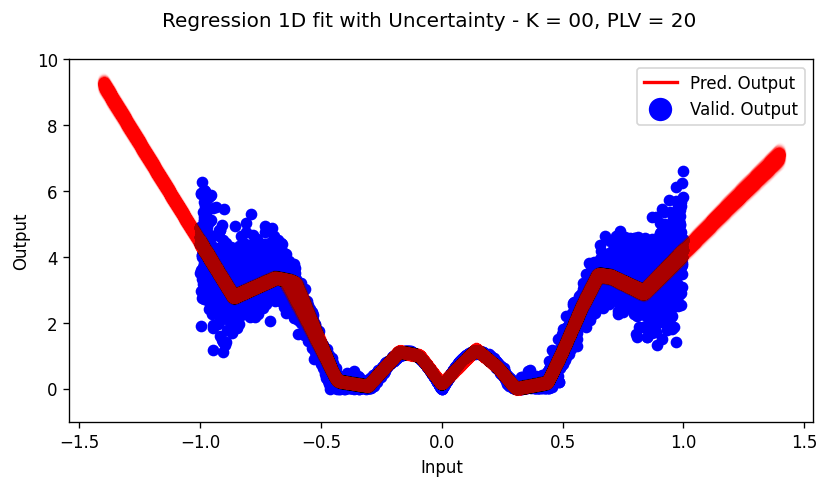

In [12]:
plot_regression(K='00', PLV='20')

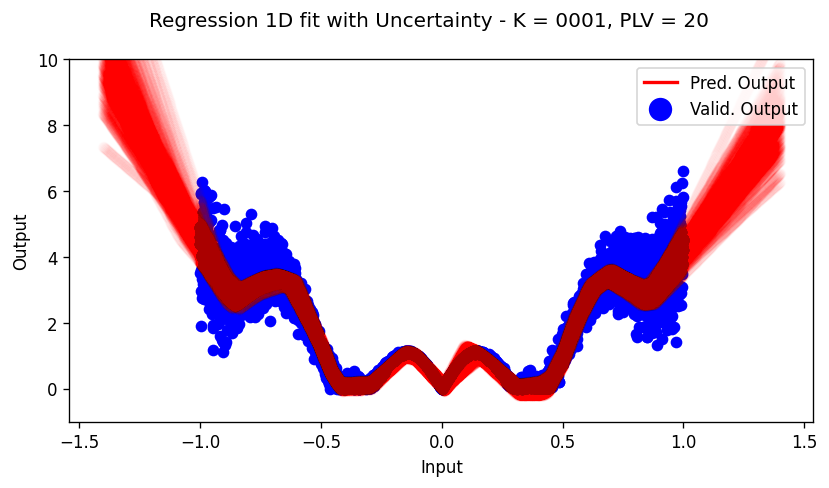

In [13]:
plot_regression(K='0001', PLV='20')

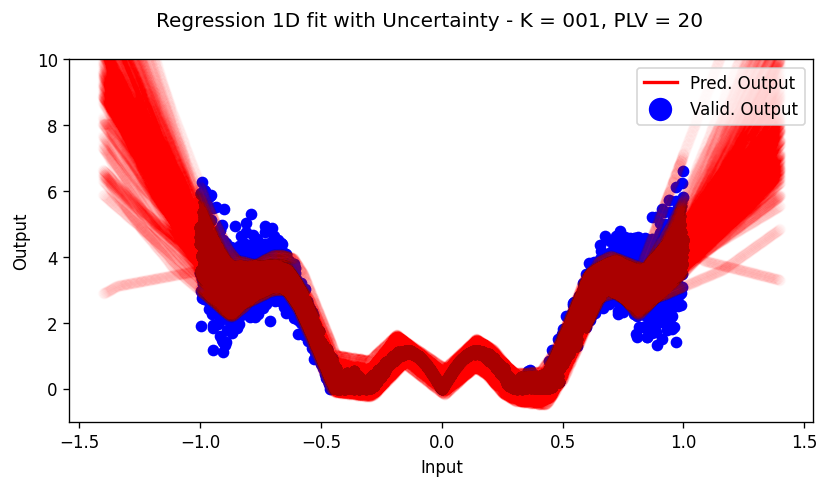

In [14]:
plot_regression(K='001', PLV='20')

In [15]:
def profit(order, sell_price, cost_price):
    return sell_price*torch.minimum(order, demand_true) - cost_price*order

def newsvendor_curve(K, PLV, M=1000):

    model = h_opt_dict[f'{K}_{PLV}']
    
    sp = 200

    zEypred_list = []
    zypred_list = []
    zy_list = []
    cp_list = list(np.arange(20,190,10))
    qtl_list = []

    for cp in cp_list:

        # Classical newsvendor problem
        sell_price = torch.tensor(sp)
        cost_price = torch.tensor(cp)
        quantile_cut = (sell_price - cost_price)/sell_price
        optimal_pred_order = torch.quantile(
            generate_demand_pred_dist(model, M), 
            quantile_cut, dim=0)
        optimal_order = demand_true

        zypred = round(profit(
            optimal_pred_order, 
            sell_price, cost_price
        ).sum().item(), 2)

        zy = round(profit(
            optimal_order, 
            sell_price, cost_price
        ).sum().item(), 2)

        qtl_list.append(quantile_cut.item())

        zypred_list.append((zy-zypred)/zy)

    return qtl_list, zypred_list

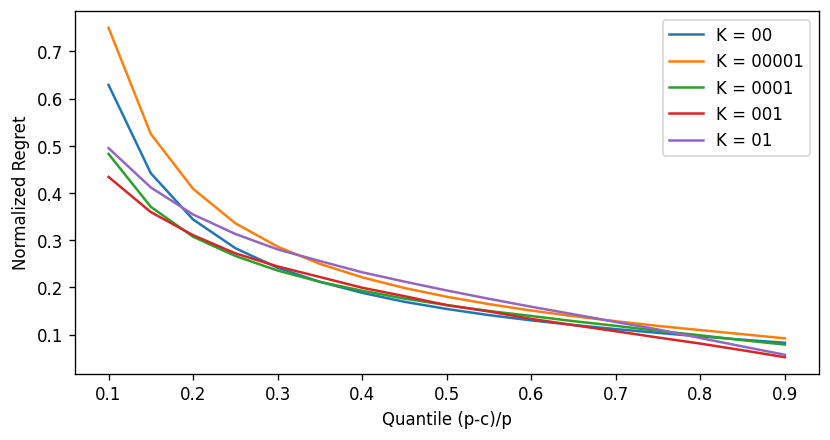

In [16]:
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.set_xlabel('Quantile (p-c)/p')
ax.set_ylabel('Normalized Regret')

for kk in ['00', '00001', '0001', '001', '01']:
    qtl_list, zypred_list = newsvendor_curve(K=f'{kk}', PLV='20', M=1000)
    ax.plot(qtl_list, zypred_list, label = f'K = {kk}')
    ax.legend()

In [17]:
def compute_normalized_regret(K, PLV, M=1000, sell_price = 200, cost_price = 150):

    model = h_opt_dict[f'{K}_{PLV}']

    quantile_cut = (sell_price - cost_price)/sell_price

    optimal_pred_order = torch.quantile(
                generate_demand_pred_dist(model, M), 
                quantile_cut, dim=0)

    optimal_order = demand_true

    zypred = round(profit(
                optimal_pred_order, 
                sell_price, cost_price
            ).sum().item(), 2)

    zy = round(profit(
        optimal_order, 
        sell_price, cost_price
    ).sum().item(), 2)

    normalized_regret = (zy-zypred)/zy
    
    return normalized_regret

In [18]:
sell_price = 200
cost_price = 180

nrs = np.zeros((len(k_list), len(plv_list)))

for i in range(0, len(k_list)):
    for j in range(0, len(plv_list)):
        nrs[i,j] = compute_normalized_regret(
                        str(k_list[i]).replace('.',''), 
                        str(plv_list[j]).replace('.',''), 
                        M=1000,
                        sell_price=sell_price, 
                        cost_price=cost_price)

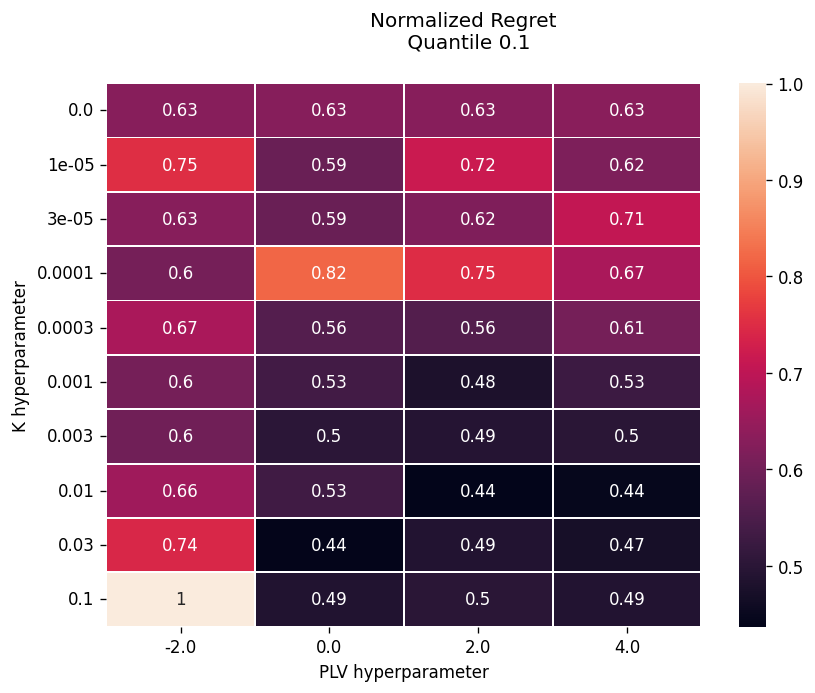

In [19]:
fig, ax = plt.subplots(figsize=(8,6),dpi=120)
ax = sns.heatmap(nrs, linewidth=0.5, xticklabels=plv_list, yticklabels=k_list, annot=True)
fig.suptitle(f'Normalized Regret \n Quantile {(sell_price - cost_price)/sell_price}')
ax.set_ylabel('K hyperparameter')
ax.set_xlabel('PLV hyperparameter')

plt.show()